추가분 이전까지의 코드는 다음 링크에서 받아왔다.
https://dacon.io/competitions/official/235961/codeshare/6021?page=1&dtype=recent

In [1]:
from zipfile import ZipFile

with ZipFile('input.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [2]:
!nvidia-smi

Tue Aug 23 01:31:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  CUDA GPU            On   | 00000000:E2:00.0 Off |                    0 |
| N/A   32C    P0    67W / 350W |   1483MiB /  8000MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import

In [3]:
import random
import pandas as pd
import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [5]:
CFG = {
    'EPOCHS':5,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':16,
    'SEED':41
}

## Fixed RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [7]:
# PATH = './input'
all_input_list = sorted(glob.glob('./train_input/*.csv'))
all_target_list = sorted(glob.glob('./train_target/*.csv'))

In [8]:
train_input_list = all_input_list[:50]
train_target_list = all_target_list[:50]

val_input_list = all_input_list[50:]
val_target_list = all_target_list[50:]

## CustomDataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, input_paths, target_paths, infer_mode):
        self.input_paths = input_paths
        self.target_paths = target_paths
        self.infer_mode = infer_mode
        
        self.data_list = []
        self.label_list = []
        print('Data Pre-processing..')
        for input_path, target_path in tqdm(zip(self.input_paths, self.target_paths)):
            input_df = pd.read_csv(input_path)
            target_df = pd.read_csv(target_path)
            
            input_df = input_df.drop(columns=['시간'])
            input_df = input_df.fillna(0)
            
            input_length = int(len(input_df)/1440)
            target_length = int(len(target_df))
            
            for idx in range(target_length):
                time_series = input_df[1440*idx:1440*(idx+1)].values
                self.data_list.append(torch.Tensor(time_series))
            for label in target_df["rate"]:
                self.label_list.append(label)
        print('Done.')
              
    def __getitem__(self, index):
        data = self.data_list[index]
        label = self.label_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data
        
    def __len__(self):
        return len(self.data_list)

In [10]:
train_dataset = CustomDataset(train_input_list, train_target_list, False)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(val_input_list, val_target_list, False)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.


In [136]:
train_dataset

## Model Define

In [11]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=37, hidden_size=256, batch_first=True, bidirectional=False)
        self.classifier = nn.Sequential(
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.classifier(hidden[:,-1,:])
        return output

## Train

In [12]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        val_loss = validation(model, val_loader, criterion, device)
        
        print(f'Train Loss : [{np.mean(train_loss):.5f}] Valid Loss : [{val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step()
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
    return best_model

In [13]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.float().to(device)
            Y = Y.float().to(device)
            
            model_pred = model(X)
            loss = criterion(model_pred, Y)
            
            val_loss.append(loss.item())
            
    return np.mean(val_loss)

## Run!!

In [14]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

best_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss : [0.29267] Valid Loss : [0.23945]


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss : [0.28272] Valid Loss : [0.24639]


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss : [0.28205] Valid Loss : [0.24664]


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss : [0.28330] Valid Loss : [0.25498]


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss : [0.27835] Valid Loss : [0.24344]


## Inference

In [15]:
test_input_list = sorted(glob.glob('./test_input/*.csv'))
test_target_list = sorted(glob.glob('./test_target/*.csv'))

In [16]:
def inference_per_case(model, test_loader, test_path, device):
    model.to(device)
    model.eval()
    pred_list = []
    with torch.no_grad():
        for X in iter(test_loader):
            X = X.float().to(device)
            
            model_pred = model(X)
            
            model_pred = model_pred.cpu().numpy().reshape(-1).tolist()
            
            pred_list += model_pred
    
    submit_df = pd.read_csv(test_path)
    submit_df['rate'] = pred_list
    submit_df.to_csv(test_path, index=False)

In [17]:
for test_input_path, test_target_path in zip(test_input_list, test_target_list):
    test_dataset = CustomDataset([test_input_path], [test_target_path], True)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    inference_per_case(best_model, test_loader, test_target_path, device)

Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.


In [29]:
import zipfile
os.chdir("./test_target/")
submission = zipfile.ZipFile("../submission.zip", 'w')
for path in test_target_list:
    path = path.split('/')[-1]
    submission.write(path)
submission.close()
os.chdir("..")

# 추가분

In [303]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [217]:
# 한글 폰트 설정
plt.style.use("seaborn-whitegrid")
plt.rc("font", family="NanumBarunGothic")
plt.rc("axes", unicode_minus=False)

%config InlineBackend.figure_format = 'retina'

In [ ]:
def input_df(num):
    data = pd.read_csv(f'./train_input/CASE_{str(num).zfill(2)}.csv')
    return data

In [241]:
dfs=[input_df(i) for i in range(1,59)]

In [256]:
for df in dfs:
#     column 이름이 약간 다른 경우가 있어 01케이스와 동일하게 통일한다
    df.columns = dfs[0].columns
#     시간대별 확인을 위해 시각을 추가한다
    df.시간 = pd.to_datetime(df.시간)
    df['시각'] = df.시간.apply(lambda x : x.hour)

## 시간대별 확인
시간대별로 값이 다를 수 있다고 생각해 확인해보았다.
시간대별로 특정한 경향을 보여 결측치에는 각 케이스별 시간대별 평균값을 넣어주었다.

In [257]:
dfs[29].columns

Index(['시간', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치',
       '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태', '냉방작동남은시간', '난방상태',
       '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간',
       '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간',
       '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도',
       '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량',
       '청색광추정광량', '시각'],
      dtype='object')

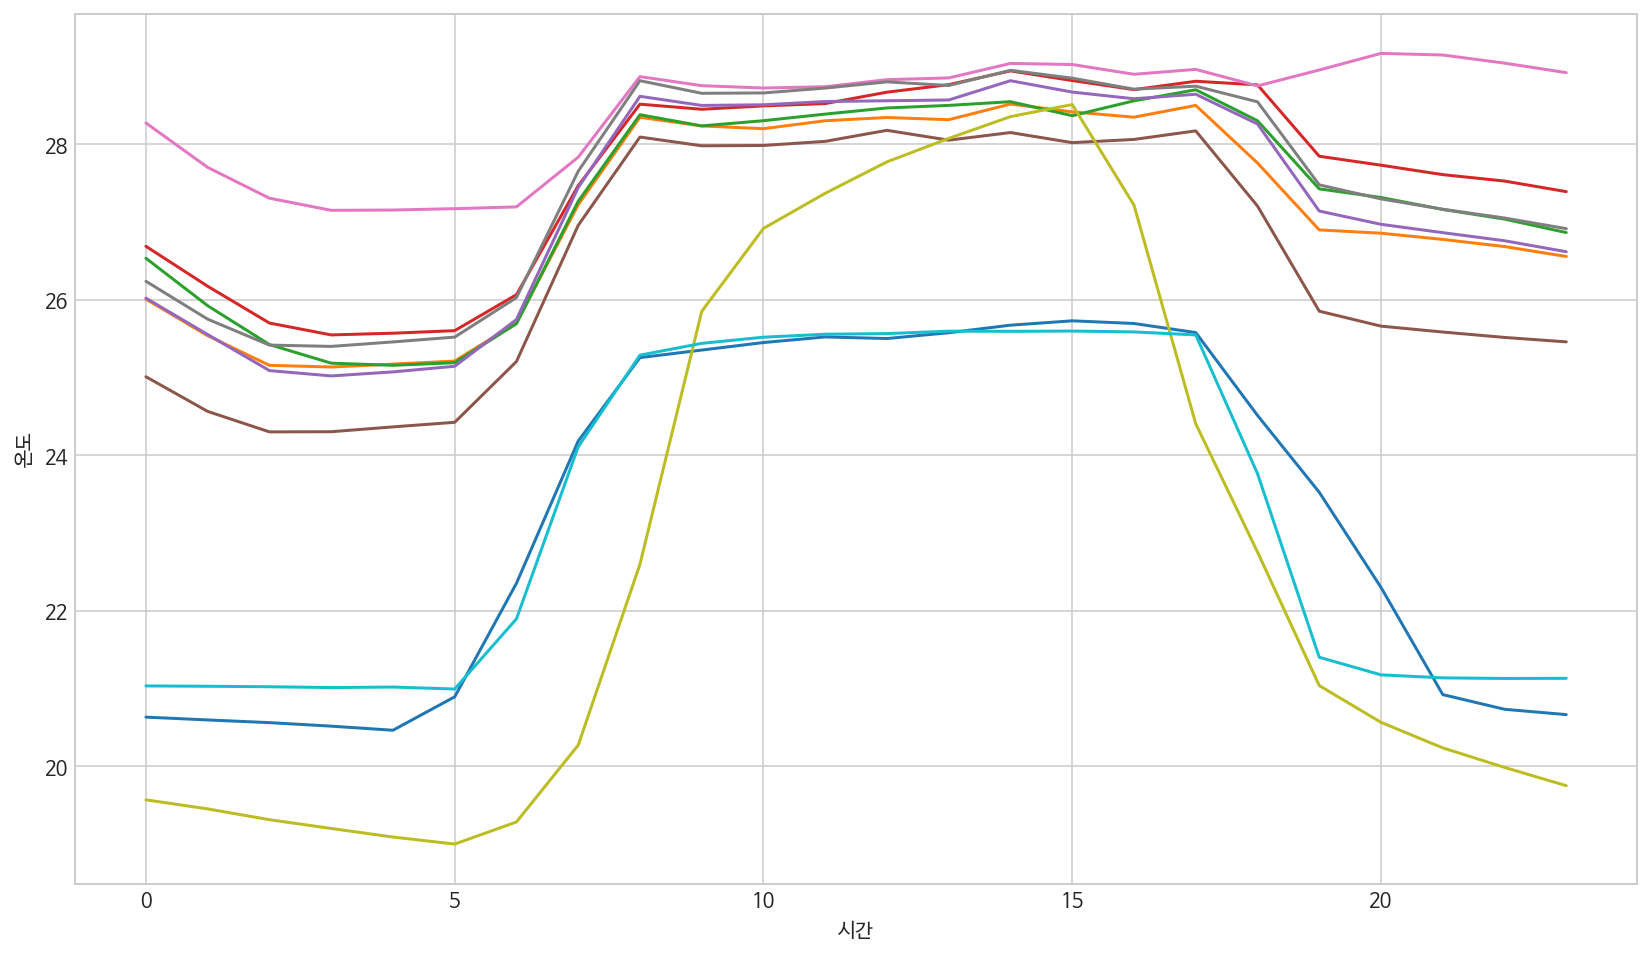

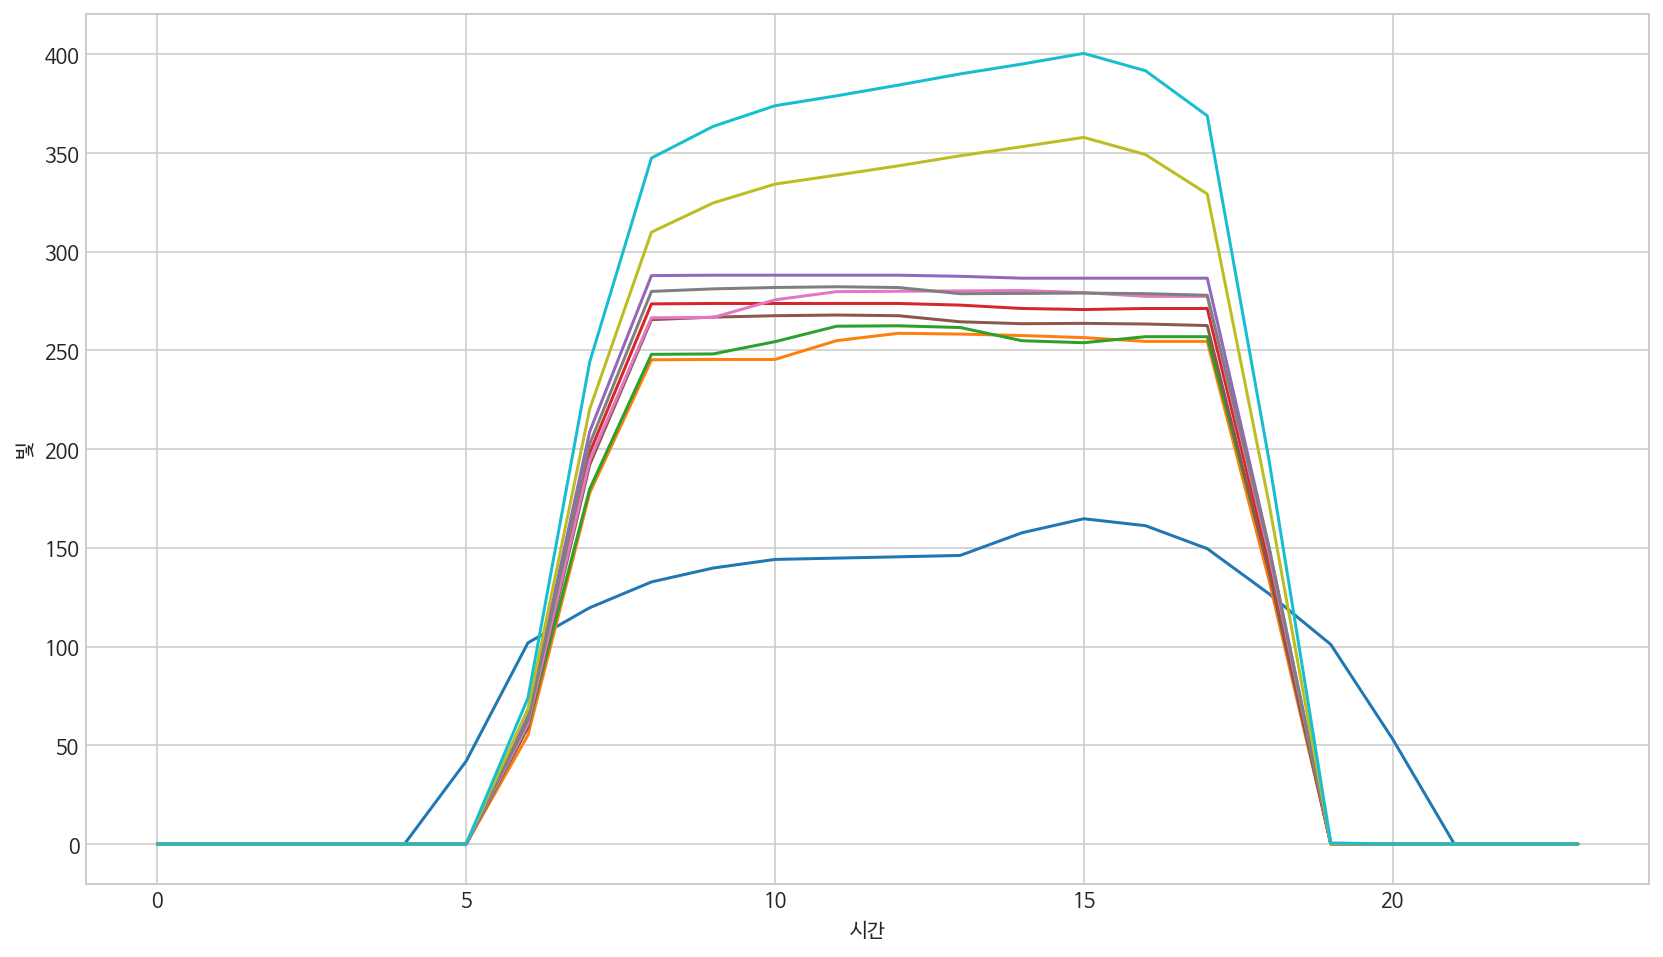

In [244]:
plt.figure(figsize=(14,8))
for i in range(10):
    df = dfs[i][['시각', '내부온도관측치']].groupby(['시각']).mean()
    plt.plot(df.index, df.내부온도관측치)
    
plt.xlabel('시간')
plt.ylabel('온도')
plt.show()

plt.figure(figsize=(14,8))
for i in range(10):
    df = dfs[i][['시각', '총추정광량']].groupby(['시각']).mean()
    plt.plot(df.index, df.총추정광량)
    
plt.xlabel('시간')
plt.ylabel('빛')
plt.show()

In [245]:
def showdiff(col=''):
    print(f'시간대별 {col} 최대최소')
    for k in range(10):
        list = [dfs[k][dfs[k].시각 == i][col].describe()[1] for i in range(24)]
        print('-'*30, 
              f'{k+1}번째 케이스', 
              f'최대 값 : {max(list)}', 
              f'최소 값 : {min(list)}', 
              f'차이 : {max(list) - min(list)}', 
              sep = '\n')
# dfs[0][dfs[0].내부온도관측치.isnull()]

In [246]:
showdiff('CO2관측치')

시간대별 CO2관측치 최대최소
------------------------------
1번째 케이스
최대 값 : 429.1471264367816
최소 값 : 355.21063218390805
차이 : 73.93649425287356
------------------------------
2번째 케이스
최대 값 : 487.3327586206897
최소 값 : 439.65201149425286
차이 : 47.68074712643681
------------------------------
3번째 케이스
최대 값 : 453.7311728395062
최소 값 : 412.6938271604938
차이 : 41.03734567901239
------------------------------
4번째 케이스
최대 값 : 540.4327586206897
최소 값 : 499.10057471264366
차이 : 41.332183908046034
------------------------------
5번째 케이스
최대 값 : 466.03218390804597
최소 값 : 424.2528735632184
차이 : 41.77931034482759
------------------------------
6번째 케이스
최대 값 : 458.8215517241379
최소 값 : 419.9511494252874
차이 : 38.870402298850536
------------------------------
7번째 케이스
최대 값 : 505.16120689655173
최소 값 : 451.6255747126437
차이 : 53.535632183908035
------------------------------
8번째 케이스
최대 값 : 506.5755747126437
최소 값 : 468.6706896551724
차이 : 37.90488505747129
------------------------------
9번째 케이스
최대 값 : 661.6808510638298
최소 값 : 441.7911

### 결측치 채우기

In [258]:
# 결측치 확인
nullbycol = dfs[0].isnull().sum()
for i in tqdm(range(1,58)):
    nullbycol += dfs[i].isnull().sum()
nullbycol

  0%|          | 0/57 [00:00<?, ?it/s]

시간                    0
내부온도관측치           73322
내부습도관측치           73322
CO2관측치            73322
EC관측치             73322
외부온도관측치          412858
외부습도관측치          412858
펌프상태              73322
펌프작동남은시간          73322
최근분무량             73322
일간누적분무량           73322
냉방상태              73322
냉방작동남은시간          73322
난방상태              73322
난방작동남은시간          73322
내부유동팬상태           73322
내부유동팬작동남은시간       73322
외부환기팬상태           73322
외부환기팬작동남은시간       73322
화이트 LED상태         73322
화이트 LED작동남은시간     73322
화이트 LED동작강도       73322
레드 LED상태          73322
레드 LED작동남은시간      73322
레드 LED동작강도        73322
블루 LED상태          73322
블루 LED작동남은시간      73322
블루 LED동작강도        73322
카메라상태             73322
냉방온도              73322
난방온도              73322
기준온도              73322
난방부하              73322
냉방부하              73322
총추정광량             73322
백색광추정광량           73322
적색광추정광량           73322
청색광추정광량           73322
시각                    0
dtype: int64

In [259]:
nullbytime = dfs[0][dfs[0]['내부온도관측치'].isnull() != 0]
for i in tqdm(range(1,58)):
    df = dfs[i]
    tmp = df[df['내부온도관측치'].isnull() != 0]
    nullbytime = pd.concat([nullbytime, tmp])

  0%|          | 0/57 [00:00<?, ?it/s]

In [260]:
nullbytime

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,...,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,시각
25395,2021-03-06 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
38473,2021-03-15 17:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
13024,2021-04-04 01:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
15056,2021-04-05 10:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
1146,2021-03-26 19:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15183,2022-05-06 13:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
15184,2022-05-06 13:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
15185,2022-05-06 13:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
15186,2022-05-06 13:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13


시간대별로 결측치 빈도수는 큰 차이가 없다

In [264]:
nulltimelist = nullbytime.시간
nullbytime['시각'] = nullbytime.시간.apply(lambda x : x.hour)
nullbytime['시각'].value_counts().sort_index()

0     2828
1     3829
2     2876
3     2852
4     2900
5     2940
6     2988
7     3023
8     3115
9     3018
10    2964
11    2847
12    2885
13    3365
14    3588
15    3586
16    3380
17    3108
18    2813
19    2870
20    2896
21    2927
22    2928
23    2796
Name: 시각, dtype: int64

<AxesSubplot:>

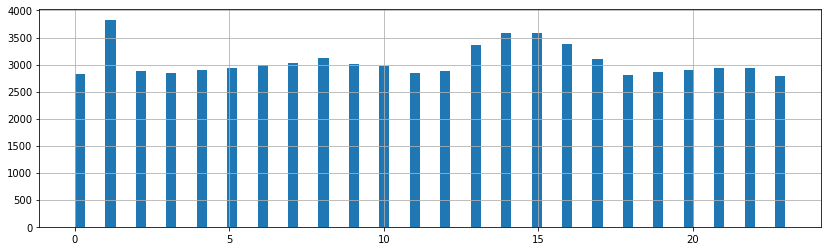

In [131]:
nullbytime['결측시'].hist(figsize=(14,4), bins=70)

In [308]:
def fillnabytime(df, col, on='시각'):
    """
    col의 결측치를 시간대별 평균값으로 넣어준다.
    """
    if df[col].isnull().sum() == 0:
        return 0
    else:
        mean = df[[on, col]].groupby(on).mean()
        idxs = df[df[col].isnull()].index
        for index in idxs:
            df.loc[index, col] = float(mean.loc[df.loc[index, on]])

In [ ]:
cols = dfs[0].columns[1:-1]
for i, df in enumerate(dfs, start=1):
    print(i)
    for col in tqdm(cols):
        fillnabytime(df,col)

In [350]:
# 결측치가 채워지지 않은 부분 확인
for i, df in enumerate(dfs):
    if df.isnull().sum().sum() == 0:
        continue
    print(i, df.columns[df.isnull().sum() != 0])

36 Index(['외부온도관측치', '외부습도관측치'], dtype='object')
38 Index(['외부온도관측치', '외부습도관측치'], dtype='object')
42 Index(['외부온도관측치', '외부습도관측치'], dtype='object')
46 Index(['외부온도관측치', '외부습도관측치'], dtype='object')
48 Index(['외부온도관측치', '외부습도관측치'], dtype='object')
49 Index(['외부온도관측치', '외부습도관측치'], dtype='object')
53 Index(['외부온도관측치', '외부습도관측치'], dtype='object')
54 Index(['외부온도관측치', '외부습도관측치'], dtype='object')


몇개의 실험에서 외부온도와 외부습도 측정이 전혀 진행되지 않았음을 확인 할 수 있다. 그러나 실험이 진행된 환경과 외부 환경은 독립적이어야하므로 실험이 잘 진행되었다면 의미가 있는 항목이 아닐 것으로 생각된다.